In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Q-Tables

| Partner Selection  | LEAVE | STAY |
| :----------------- | :---: | :--: |
| PARTNER_DEFECTED   | 0     | 0    |
| PARTNER_COOPERATED | 0     | 0    |

`LEAVE` and `STAY` are the two actions in the partner selection stage.  
If two agents are paired and one agent chooses to leave then both agents will be added to a pool. 
After all agents have made their choices agents in the pool are randomly paired. 
If both agents choose to stay then they will remain paired for the prisoner's dilemma stage.

| Prisoner's Dilemma  | DEFECT | COOPERATE |
| :------------------ | :----: | :-------: |
| PARTNER_DEFECTED    | 0      | 0         |
| PARTNER_COOPERATED  | 0      | 0         |

`DEFECT` and `COOPERATE` are the two actions in the prisoner's dilemma stage.
Agents are given rewards in the prisoner's dilemma stage which can be seen in the table below 
where ($r_i$, $r_j$) is the returned rewards for agents `i` and `j`

|                    | `j` Defects | `j` Cooperates |
| ------------------ | ----------- | -------------- |
| **`i` Defects**    | (1, 1)      | (5, 0)         |
| **`i` Cooperates** | (0, 5)      | (3, 3)         |


In [48]:
from enum import Enum

class ActionPS(Enum):
    LEAVE = 0
    STAY = 1

class ActionPD(Enum):
    DEFECT = 0
    COOPERATE = 1

class State(Enum):
    PARTNER_DEFECTED = 0
    PARTNER_COOPERATED = 1

def get_state(action: ActionPD) -> State:
    return State.PARTNER_COOPERATED if action == ActionPD.COOPERATE else State.PARTNER_DEFECTED

In [49]:
class StrategyPS(Enum):
    ALWAYS_STAY = 0
    OUT_FOR_TAT = 1
    REVERSE_OUT_FOR_TAT = 2
    ALWAYS_LEAVE = 3
    RANDOM = 4

class StrategyPD(Enum):
    ALWAYS_COOPERATE = 0
    TIT_FOR_TAT = 1
    REVERSE_TIT_FOR_TAT = 2
    ALWAYS_DEFECT = 3
    RANDOM = 4
    
strategy_names = {
    StrategyPS.ALWAYS_STAY : 'Always-Stay',
    StrategyPS.OUT_FOR_TAT : 'Out-For-Tat',
    StrategyPS.REVERSE_OUT_FOR_TAT : 'Reverse-OFT',
    StrategyPS.ALWAYS_LEAVE : 'Always-Leave',
    StrategyPS.RANDOM : 'Random (PS)',
    StrategyPD.ALWAYS_COOPERATE : 'Always-Cooperate',
    StrategyPD.TIT_FOR_TAT : 'Tit-For-Tat',
    StrategyPD.REVERSE_TIT_FOR_TAT : 'Reverse-TFT',
    StrategyPD.ALWAYS_DEFECT : 'Always-Defect',
    StrategyPD.RANDOM : 'Random (PD)',
}

strategy_colors = {
    StrategyPS.ALWAYS_STAY : 'lightcoral',
    StrategyPS.OUT_FOR_TAT : 'lightsteelblue',
    StrategyPS.REVERSE_OUT_FOR_TAT : 'lightgreen',
    StrategyPS.ALWAYS_LEAVE : 'tan',
    StrategyPS.RANDOM : 'mediumpurple',
    StrategyPD.ALWAYS_COOPERATE : 'red',
    StrategyPD.TIT_FOR_TAT : 'blue',
    StrategyPD.REVERSE_TIT_FOR_TAT : 'green',
    StrategyPD.ALWAYS_DEFECT : 'yellow',
    StrategyPD.RANDOM : 'purple',
}


In [50]:
# returns the probabilities of selection actions given the current state 
def boltzmann_exploration(q_table, state: State, temperature: float, constant):
    exp = np.exp((q_table[state.value, :] - max(q_table[state.value, :])) / temperature)
    return exp / np.sum(exp)

def epsilon_greedy(q_table, state: State, epsilon: float) -> np.ndarray:
    if np.random.rand() < epsilon:
        return np.ones(len(q_table[state.value, :])) / len(q_table[state.value, :])
    else:
        prob = np.zeros(len(q_table[state.value, :]))
        prob[np.argmax(q_table[state.value, :])] = 1
        return prob

In [51]:
# runs the Q-Learning algorithm on the provided qtable
# NOTE: alpha is the learning rate and gamma is the discount rate
def q_learning(qtable, next_qtable, state: State, action, 
               reward: float, new_state: State, alpha: float, gamma: float) -> None:
    qtable[state.value, action.value] = (1.0 - alpha) * qtable[state.value, action.value] + \
        alpha * (reward + gamma * np.max(next_qtable[new_state.value, :]))

In [52]:
class Agent:
    def __init__(self, learning_rate: float, temperature: float, discount_rate: float, 
                 last_action: ActionPD = None, qtable_ps = None, qtable_pd = None):
        self.a = learning_rate
        self.t = temperature
        self.g = discount_rate
        self.last_action = np.random.choice([ActionPD.DEFECT, ActionPD.COOPERATE], 1) if last_action == None else last_action
        self.qtable_ps = np.zeros((2, 2)) if qtable_ps is None else qtable_ps
        self.qtable_pd = np.zeros((2, 2)) if qtable_pd is None else qtable_pd

        # Force agents to use Out For Tat Partner Selection Strategy
        # self.qtable_ps[0, 0] = 10
        # self.qtable_ps[1, 1] = 10
        
    # returns an action given the current state
    def get_action_ps(self, state: State, debug = False) -> ActionPS:
        temp = boltzmann_exploration(self.qtable_ps, state, self.t, 0.8)
        action = np.random.choice([ActionPS.LEAVE, ActionPS.STAY], p=temp)
        if debug:
            print("Action Probabilities: " + str(temp))
            print("Chosen Action: " + str(action))
        return action

        # Force Out for Tat
        # if state == State.PARTNER_COOPERATED:
        #     return ActionPS.STAY
        # else:
        #     return ActionPS.LEAVE

    def get_action_pd(self, state: State, debug = False) -> ActionPD:
        temp = boltzmann_exploration(self.qtable_pd, state, self.t, 0.8)
        action = np.random.choice([ActionPD.DEFECT, ActionPD.COOPERATE], p=temp)
        if debug:
            print("Action Probabilities: " + str(temp))
            print("Chosen Action: " + str(action))
        return action
    
    def update_reward(self, reward):
        pass
    
    # trains using trajectories from each round
    def train(self, trajectories, debug = False):
        
        # Author's Implementation

        # discounted_rewards = []
        # running_sum = 0
        # for trajectory in trajectories[::-1]:
        #     running_sum = trajectory[6] + self.g * running_sum
        #     discounted_rewards.append(running_sum)
        # discounted_rewards.reverse()

        # for idx, trajectory in enumerate(trajectories):
        #     # partner selection training
        #     q_learning(self.qtable_ps, self.qtable_pd, trajectory[0], trajectory[1], discounted_rewards[idx], trajectory[3], self.a, self.g)
        #     # prisoner's dilemma training
        #     q_learning(self.qtable_pd, self.qtable_ps, trajectory[3], trajectory[4], discounted_rewards[idx], trajectory[5], self.a, self.g)

        # Interpreted Implementation

        for idx, trajectory in enumerate(trajectories):
            # partner selection training
            q_learning(self.qtable_ps, self.qtable_pd, trajectory[0], trajectory[1], trajectory[2], trajectory[3], self.a, self.g)
            # prisoner's dilemma training
            q_learning(self.qtable_pd, self.qtable_ps, trajectory[3], trajectory[4], trajectory[6], trajectory[5], self.a, self.g)
                
        # decrease temperature
            #self.t *= 0.01
            self.t *= 0.998
    
    def get_strategy_ps(self):
        if (self.qtable_ps[0, 0] < self.qtable_ps[0, 1] and self.qtable_ps[1, 0] < self.qtable_ps[1, 1]):
            return StrategyPS.ALWAYS_STAY
        elif (self.qtable_ps[0, 0] > self.qtable_ps[0, 1] and self.qtable_ps[1, 0] < self.qtable_ps[1, 1]):
            return StrategyPS.OUT_FOR_TAT
        elif (self.qtable_ps[0, 0] < self.qtable_ps[0, 1] and self.qtable_ps[1, 0] > self.qtable_ps[1, 1]):
            return StrategyPS.REVERSE_OUT_FOR_TAT
        elif (self.qtable_ps[0, 0] > self.qtable_ps[0, 1] and self.qtable_ps[1, 0] > self.qtable_ps[1, 1]):
            return StrategyPS.ALWAYS_LEAVE
        else:
            return StrategyPS.RANDOM

    def get_strategy_pd(self):
        if (self.qtable_pd[0, 0] < self.qtable_pd[0, 1] and self.qtable_pd[1, 0] < self.qtable_pd[1, 1]):
            return StrategyPD.ALWAYS_COOPERATE
        elif (self.qtable_pd[0, 0] > self.qtable_pd[0, 1] and self.qtable_pd[1, 0] < self.qtable_pd[1, 1]):
            return StrategyPD.TIT_FOR_TAT
        elif (self.qtable_pd[0, 0] < self.qtable_pd[0, 1] and self.qtable_pd[1, 0] > self.qtable_pd[1, 1]):
            return StrategyPD.REVERSE_TIT_FOR_TAT
        elif (self.qtable_pd[0, 0] > self.qtable_pd[0, 1] and self.qtable_pd[1, 0] > self.qtable_pd[1, 1]):
            return StrategyPD.ALWAYS_DEFECT
        else:
            return StrategyPD.RANDOM
    


In [53]:
# returns the rewards of two agents in the prisoner's dilemma game
def prisoners_dilemma(a_i: ActionPD, a_j: ActionPD) -> tuple[float, float]:
    reward_table = np.array([[(1, 1), (5, 0)], [(0, 5), (3, 3)]])
    return reward_table[a_i.value, a_j.value]

# Trajectories
Each agent tracks the folowing figures each round as a trajectory:  
- $(s_{PS}, a_{PS}, r_{PS} = 0, s'_{PS} = s_{PD}, a_{PD}, s'_{PD}, r_{PD})$
- $s_{PS}$ is the state of the agent in the partner selection stage.  
- $a_{PS}$ is the action the agent made in the partner selection stage.  
- $r_{PS}$ is the reward the agent recieved from the partner selection stage. ~~This will always be zero and is not recorded~~.  
- $s'_{PS}$ is the new state after the prisoner selection stage which is equivalent to the state in the prisoner's dilemma stage $s_{PD}$.  
- $a_{PD}$ is the action the agent made in the prisoner's dilemma stage.  
- $s'_{PS}$ is the new state after the prisoner's dilemma stage.  
- $r_{PD}$ is the reward the agent recieved from the prisoners dilemma stage.  


In [54]:
def sdoo(population: int, rounds: int, episodes: int, learning_rate: float, temperature: float, discount_rate: float):
    if (population % 2 != 0):
        print("sdoo: population must be a multiple of two")
        return
    
    recorded_outcomes_pd = {
        (ActionPD.DEFECT, ActionPD.DEFECT): [0 for _ in range(episodes)],
        (ActionPD.DEFECT, ActionPD.COOPERATE): [0 for _ in range(episodes)],
        (ActionPD.COOPERATE, ActionPD.DEFECT): [0 for _ in range(episodes)],
        (ActionPD.COOPERATE, ActionPD.COOPERATE): [0 for _ in range(episodes)],
    }

    recorded_agent_strategy_pairings = {
        # (a, b): [0 for _ in range(episodes)] for a in StrategyPD for b in StrategyPD
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.ALWAYS_COOPERATE): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.REVERSE_TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.ALWAYS_COOPERATE, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        (StrategyPD.TIT_FOR_TAT, StrategyPD.TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.TIT_FOR_TAT, StrategyPD.REVERSE_TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.TIT_FOR_TAT, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.TIT_FOR_TAT, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        (StrategyPD.REVERSE_TIT_FOR_TAT, StrategyPD.REVERSE_TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.REVERSE_TIT_FOR_TAT, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.REVERSE_TIT_FOR_TAT, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_DEFECT, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.ALWAYS_DEFECT, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        # (StrategyPD.RANDOM, StrategyPD.RANDOM): [0 for _ in range(episodes)],
    }

    recorded_outcome_changes = {
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],

        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],

        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],

        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],
    }

    agent_qvales_ps = [[0 for _ in range(episodes)] for _ in range(4)]
    agent_qvales_pd = [[0 for _ in range(episodes)] for _ in range(4)]

    recorded_qvalues_ps = [[[0 for _ in range(episodes)] for _ in range(4)] for _ in range(population)]
    recorded_qvalues_pd = [[[0 for _ in range(episodes)] for _ in range(4)] for _ in range(population)]

    agent_ps_actions_per_episode = [[0 for _ in range(episodes)] for _ in range(4)]
    percentage_of_states_per_episode = [[0 for _ in range(episodes)] for _ in range(4)]

    agent_chosen_switches_per_episode = [0 for _ in range(episodes)]
    agent_switches_per_episode = [0 for _ in range(episodes)]

    total_reward = [0 for _ in range(episodes)]

    # Fix Randoms
    # np.random.seed(0)

    # Global Q-Table Test
    # qtable_ps = np.zeros((2, 2))
    # qtable_pd = np.zeros((2, 2))
    # agents = [Agent(learning_rate, temperature, discount_rate, qtable_ps=qtable_ps, qtable_pd=qtable_pd) for _ in range(population)]

    agents = [Agent(learning_rate, temperature, discount_rate) for _ in range(population)]
    unpaired = list(range(population))

    # Pair Agents
    pairs: tuple[int, int] = []
    while unpaired:
        i = unpaired.pop(np.random.randint(len(unpaired)))
        j = unpaired.pop(np.random.randint(len(unpaired)))
        pairs.append((i, j))

    
    for episode in range(episodes):
        # Record agent Q-Values
        for agent_idx in range(len(recorded_qvalues_ps)):
            for idx in range(len(recorded_qvalues_ps[agent_idx])):
                recorded_qvalues_ps[agent_idx][idx][episode] = agents[agent_idx].qtable_ps.ravel()[idx]

        for agent_idx in range(len(recorded_qvalues_pd)):
            for idx in range(len(recorded_qvalues_pd[agent_idx])):
                recorded_qvalues_pd[agent_idx][idx][episode] = agents[agent_idx].qtable_pd.ravel()[idx]


        trajectories = [[] for _ in range(population)]
        for round in range(rounds):

            # Partner Selection
            temp_pairs = []
            for (i, j) in pairs:
                s_i = get_state(agents[j].last_action)
                s_j = get_state(agents[i].last_action)
                percentage_of_states_per_episode[s_i.value][episode] += 1
                percentage_of_states_per_episode[s_j.value][episode] += 1

                a_i = agents[i].get_action_ps(s_i)
                a_j = agents[j].get_action_ps(s_j)
                if a_i == ActionPS.LEAVE or a_j == ActionPS.LEAVE:
                    unpaired.append(i)
                    unpaired.append(j)
                    agent_switches_per_episode[episode] += 2
                    agent_chosen_switches_per_episode[episode] += int(a_i == ActionPS.LEAVE) + int(a_j == ActionPS.LEAVE)
                else:
                    temp_pairs.append((i, j))

                # Partner Selection Rewards Test
                r_i = 1 if a_j == ActionPS.STAY else -1
                r_j = 1 if a_i == ActionPS.STAY else -1
                
                # r_i = 0
                # r_j = 0
                
                trajectories[i].append((s_i, a_i, r_i))
                trajectories[j].append((s_j, a_j, r_j))

            # Pair Agents
            pairs = temp_pairs
            while unpaired:
                i = unpaired.pop(np.random.randint(len(unpaired)))
                j = unpaired.pop(np.random.randint(len(unpaired)))
                pairs.append((i, j))

            # Prisoner's Dilemma
            for (i, j) in pairs:
                strategy_i = agents[i].get_strategy_pd()
                strategy_j = agents[j].get_strategy_pd()
                if (strategy_i, strategy_j) in recorded_agent_strategy_pairings:
                    recorded_agent_strategy_pairings[(strategy_i, strategy_j)][episode] += 1
                elif (strategy_j, strategy_i) in recorded_agent_strategy_pairings:
                    recorded_agent_strategy_pairings[(strategy_j, strategy_i)][episode] += 1

                s_i = get_state(agents[j].last_action)
                s_j = get_state(agents[i].last_action)
                percentage_of_states_per_episode[(s_i.value) + 2][episode] += 1
                percentage_of_states_per_episode[(s_j.value) + 2][episode] += 1

                a_i = agents[i].get_action_pd(s_i)
                a_j = agents[j].get_action_pd(s_j)
                r_i, r_j = prisoners_dilemma(a_i, a_j)
                total_reward[episode] += r_i + r_j
                
                ns_i = get_state(a_j)
                ns_j = get_state(a_i)
                recorded_outcomes_pd[(a_i, a_j)][episode] += 1
                agents[i].last_action = a_i
                agents[j].last_action = a_j


                # Record Trajectories
                t = trajectories[i][round]
                trajectories[i][round] = (t[0], t[1], t[2], s_i, a_i, ns_i, r_i)
                t = trajectories[j][round]
                trajectories[j][round] = (t[0], t[1], t[2], s_j, a_j, ns_j, r_j)

                # Record Actions taken
                agent_ps_actions_per_episode[2 * (s_i.value - 2) + a_i.value][episode] += 1
                agent_ps_actions_per_episode[2 * (s_j.value - 2) + a_j.value][episode] += 1

        # print()
        for idx, agent in enumerate(agents):
            agent.train(trajectories[idx])
            # agent.train(trajectories[idx], debug=(idx == 0))

        for idx in range(len(agent_qvales_ps)):
            agent_qvales_ps[idx][episode] = np.sum([agent.qtable_ps.ravel()[idx] for agent in agents]) / len(agents)

        for idx in range(len(agent_qvales_pd)):
            agent_qvales_pd[idx][episode] = np.sum([agent.qtable_pd.ravel()[idx] for agent in agents]) / len(agents)

        recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.DEFECT)][episode] /= (rounds * population / 2)
        recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.COOPERATE)][episode] /= (rounds * population / 2)
        recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.DEFECT)][episode] /= (rounds * population / 2)
        recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.COOPERATE)][episode] /= (rounds * population / 2)

        agent_ps_actions_per_episode[0][episode] /= (rounds * population)
        agent_ps_actions_per_episode[1][episode] /= (rounds * population)
        agent_ps_actions_per_episode[2][episode] /= (rounds * population)
        agent_ps_actions_per_episode[3][episode] /= (rounds * population)

        percentage_of_states_per_episode[0][episode] /= (rounds * population)
        percentage_of_states_per_episode[1][episode] /= (rounds * population)
        percentage_of_states_per_episode[2][episode] /= (rounds * population)
        percentage_of_states_per_episode[3][episode] /= (rounds * population)

        for agent_trajectories in trajectories:
            for idx in range(rounds - 1):
                outcome = (agent_trajectories[idx][4], ActionPD.COOPERATE if agent_trajectories[idx][5] == State.PARTNER_COOPERATED else ActionPD.DEFECT)
                next_outcome = (agent_trajectories[idx + 1][4], ActionPD.COOPERATE if agent_trajectories[idx + 1][5] == State.PARTNER_COOPERATED else ActionPD.DEFECT)
                # if (outcome, next_outcome) in recorded_outcome_changes:
                recorded_outcome_changes[(outcome, next_outcome)][episode] += 1
                # else:
                #     recorded_outcome_changes[((outcome[1], outcome[0]), (next_outcome[1], next_outcome[0]))][episode] += 1
        
    # for agent_idx in range(recorded_qvalues_ps):
    #         for idx in range(recorded_qvalues_ps[agent_idx]):
    #             recorded_qvalues_ps[agent_idx][idx][episodes] = agent.qtable_ps.ravel()[idx]

    # Plot Prisoner's Dilemma Outcomes
    plt.plot(recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.COOPERATE)], linewidth=1)
    plt.plot(recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.COOPERATE)], linewidth=1)
    
    plt.title("Percentage of Prisoner's Dilemma Outcomes Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Outcomes')
    plt.legend(["(D, D)", "(D, C)", "(C, D)", "(C, C)", "Total Reward"])
    plt.show()


    # Plot Total Rewards
    plt.plot(total_reward, linewidth=3)

    plt.title("Total Reward Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.ylim(0, 6 * population * rounds / 2)
    plt.show()


    # Plot Agent/Pair Switches Per Episode
    plt.plot(np.divide(agent_chosen_switches_per_episode, rounds * population))
    plt.plot(np.divide(agent_switches_per_episode, rounds * population))

    plt.title("Percentage of Switches Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(["Agents Who Chose to Switch Partners", "Agents Who Switched Partners"])
    plt.show()


    # Plot Percentage of Agent PD Actions Per Episode Given State
    plt.plot(agent_ps_actions_per_episode[0])
    plt.plot(agent_ps_actions_per_episode[1])
    plt.plot(agent_ps_actions_per_episode[2])
    plt.plot(agent_ps_actions_per_episode[3])
    
    plt.title("Percentage of PD Actions Per Episode Given State")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(["Defected Given Parter Previously Defected", "Cooperated Given Parter Previously Defected", 
                "Defected Given Parter Previously Cooperated", "Cooperated Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    # Plot Percentage of Agent States Per Episode
    plt.subplot(211)
    plt.plot(percentage_of_states_per_episode[0])
    plt.plot(percentage_of_states_per_episode[1])
    
    plt.title("Percentage of Partner Selection Agent States Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of States')
    plt.legend(["Partner Selection Where Parter Previously Defected", "Partner Selection Where Parter Previously Cooperated"], 
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    plt.subplot(212)
    plt.plot(percentage_of_states_per_episode[2], linestyle='dotted')
    plt.plot(percentage_of_states_per_episode[3], linestyle='dotted')
    
    plt.title("Percentage of Prisoner's Dilemma Agent States Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of States')
    plt.legend(["Prisoner's Dilemma Where Parter Previously Defected", "Prisoner's Dilemma Where Parter Previously Cooperated"], 
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()



    num_strategies_ps = [0 for _ in StrategyPS]
    num_strategies_pd = [0 for _ in StrategyPD]

    strategy_combinations = np.zeros((len(StrategyPS), len(StrategyPD)))

    # Determine Agent Strategies
    for idx, agent in enumerate(agents):
        strategy_ps = agent.get_strategy_ps()
        strategy_pd = agent.get_strategy_pd()
        
        num_strategies_ps[strategy_ps.value] += 1
        num_strategies_pd[strategy_pd.value] += 1
        strategy_combinations[strategy_ps.value, strategy_pd.value] += 1
        
        print("Agent %i) PS-Strategy: %s, PD-Strategy: %s" % 
            (idx, strategy_names[strategy_ps], strategy_names[strategy_pd]))
        print(agent.qtable_ps)
        print(agent.qtable_pd)

    plt.subplot(211)
    ps_colors = [strategy_colors[strategy] for strategy in StrategyPS]
    plt.bar([strategy_names[strategy] for strategy in StrategyPS], num_strategies_ps, color=ps_colors)
    plt.title('PS-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()

    plt.subplot(212)
    pd_colors = [strategy_colors[strategy] for strategy in StrategyPD]
    plt.bar([strategy_names[strategy] for strategy in StrategyPD], num_strategies_pd, color=pd_colors)
    plt.title('PD-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()


    # Plot agent partner selection and prisoner's dilemma strategy combinations
    combination_indices = [i for i in range(len(strategy_combinations.ravel()))]
    ps_combination_colors = np.repeat([strategy_colors[strategy] for strategy in StrategyPS], 5)
    pd_combination_colors = np.tile([strategy_colors[strategy] for strategy in StrategyPD], 5)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2.0, color=ps_combination_colors)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2.0, bottom=(strategy_combinations.ravel() / 2.0), color=pd_combination_colors)
    plt.title('Final Strategy Combinations')
    plt.xlabel('Strategy Combination')
    plt.ylabel('Number of Agents')
    # plt.ylim(0, population)
    plt.legend(
        [plt.Rectangle((0, 0), 1, 1, color=value) for key, value in strategy_colors.items()],
        [strategy_names[key] for key, value in strategy_colors.items()],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.35),
        ncol=5,
    )
    plt.show()


    # Plot Prisoner's Dilemma Strategy Pairings
    for pairing, values in recorded_agent_strategy_pairings.items():
        plt.plot(values, '-', color=strategy_colors[pairing[0]], linewidth=3)
        plt.plot(values, '--', color=strategy_colors[pairing[1]], linewidth=3)
    
    plt.title("Prisoner's Dilemma Strategy Pairings Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Number of Pairings')
    plt.legend(
        [plt.Rectangle((0, 0), 1, 1, color=strategy_colors[strategy]) for strategy in StrategyPD],
        [strategy_names[strategy] for strategy in StrategyPD],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.35),
        ncol=5,
    )
    plt.show()


    # Plot Average Partner Selection Q-Values in each episode
    plt.plot(agent_qvales_ps[0])
    plt.plot(agent_qvales_ps[1])
    plt.plot(agent_qvales_ps[2], linestyle='dotted')
    plt.plot(agent_qvales_ps[3], linestyle='dotted')
    
    plt.title("Partner Selection Q-Values in each episode")
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(["Leave Given Parter Previously Defected", "Stay Given Parter Previously Defected", 
                "Leave Given Parter Previously Cooperated", "Stay Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()


    # Plot Average Prisoner's Dilemma Q-Values in each episode
    plt.plot(agent_qvales_pd[0])
    plt.plot(agent_qvales_pd[1])
    plt.plot(agent_qvales_pd[2], linestyle='dotted')
    plt.plot(agent_qvales_pd[3], linestyle='dotted')
    
    plt.title("Prisoner's Dilemma Q-Values in each episode")
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(["Defect Given Parter Previously Defected", "Cooperate Given Parter Previously Defected", 
                "Defect Given Parter Previously Cooperated", "Cooperate Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    # Plot Agents Prisoner's Dilemma Q-Values in each episode
    for idx in range(population):
        plt.subplot(211)
        plt.plot(recorded_qvalues_ps[idx][0])
        plt.plot(recorded_qvalues_ps[idx][1])
        plt.plot(recorded_qvalues_ps[idx][2], linestyle='dotted')
        plt.plot(recorded_qvalues_ps[idx][3], linestyle='dotted')
        
        plt.title("Agent " + str(idx) + " Partner Selection Q-Values in each episode")
        plt.xlabel('Episode')
        plt.ylabel('Q-Value')
        plt.legend(["Leave Given Parter Previously Defected", "Stay Given Parter Previously Defected", 
                    "Leave Given Parter Previously Cooperated", "Stay Given Parter Previously Cooperated"],
                    loc='center left', bbox_to_anchor=(1.04, 0.5))
        plt.show()

        plt.subplot(212)
        plt.plot(recorded_qvalues_pd[idx][0])
        plt.plot(recorded_qvalues_pd[idx][1])
        plt.plot(recorded_qvalues_pd[idx][2], linestyle='dotted')
        plt.plot(recorded_qvalues_pd[idx][3], linestyle='dotted')
        
        plt.title("Agent " + str(idx) + " Prisoner's Dilemma Q-Values in each episode")
        plt.xlabel('Episode')
        plt.ylabel('Q-Value')
        plt.legend(["Defect Given Parter Previously Defected", "Cooperate Given Parter Previously Defected", 
                    "Defect Given Parter Previously Cooperated", "Cooperate Given Parter Previously Cooperated"],
                    loc='center left', bbox_to_anchor=(1.04, 0.5))
        plt.show()


    # plot recorded outcome changes
    outcome_changes_legend = []
    for keys, changes in recorded_outcome_changes.items():
        if keys[0] == (ActionPD.COOPERATE, ActionPD.COOPERATE):
            style = 'solid'
        elif keys[0] == (ActionPD.COOPERATE, ActionPD.DEFECT):
            style = 'dotted'
        elif keys[0] == (ActionPD.DEFECT, ActionPD.COOPERATE):
            style = 'dashed'
        elif keys[0] == (ActionPD.DEFECT, ActionPD.DEFECT):
            style = 'dashdot'

        if keys[1] == (ActionPD.COOPERATE, ActionPD.COOPERATE):
            color = 'red'
        elif keys[1] == (ActionPD.COOPERATE, ActionPD.DEFECT):
            color = 'green'
        elif keys[1] == (ActionPD.DEFECT, ActionPD.COOPERATE):
            color = 'orange'
        elif keys[1] == (ActionPD.DEFECT, ActionPD.DEFECT):
            color = 'blue'
        
        changes = np.divide(changes, rounds * population)

        plt.plot(changes, linestyle=style, color=color)
        outcome_changes_legend.append("(%s, %s) -> (%s, %s)" % (keys[0][0].name, keys[0][1].name, keys[1][0].name, keys[1][1].name))
    

    # Plot the changes in outcomes for prisoner's dilemma games per episode
    plt.title("Prisoner's Dilemma Outcome Changes Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Changes')
    plt.legend(outcome_changes_legend, loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

# Notes

The values in the Prisoner's Dilemma Q-Table aproaches the values in the partner selction Q-Table plus one.

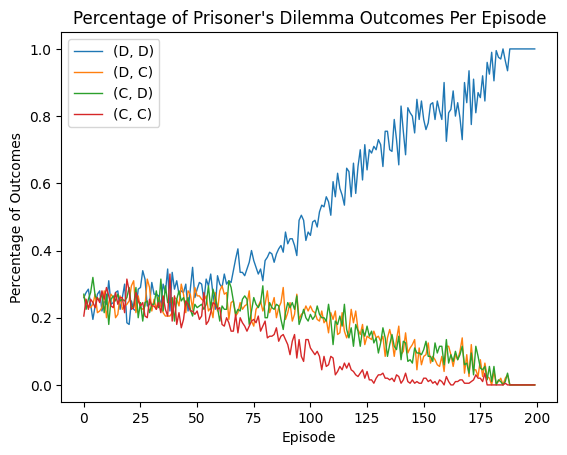

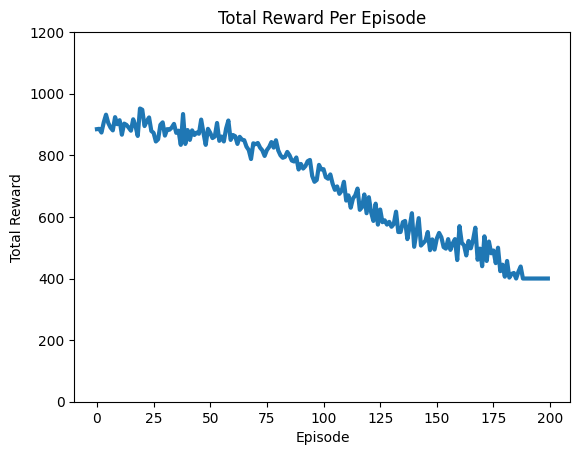

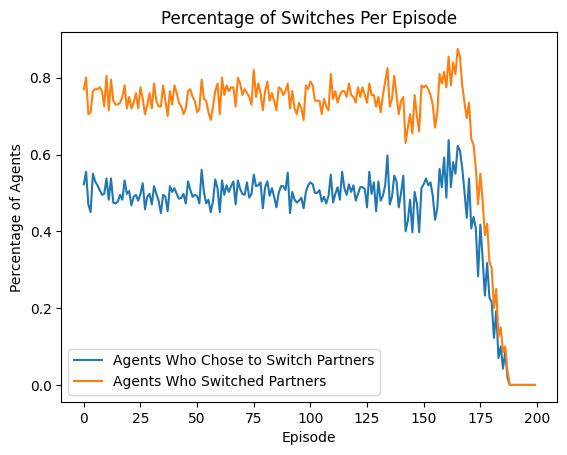

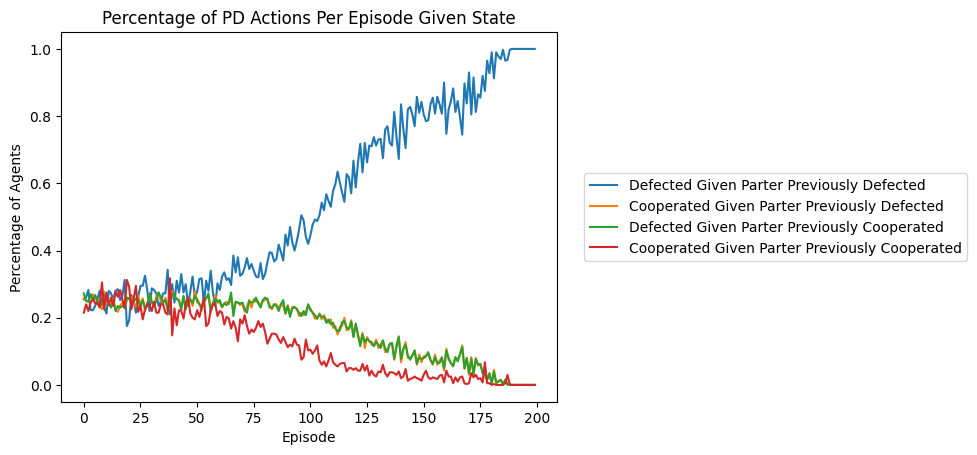

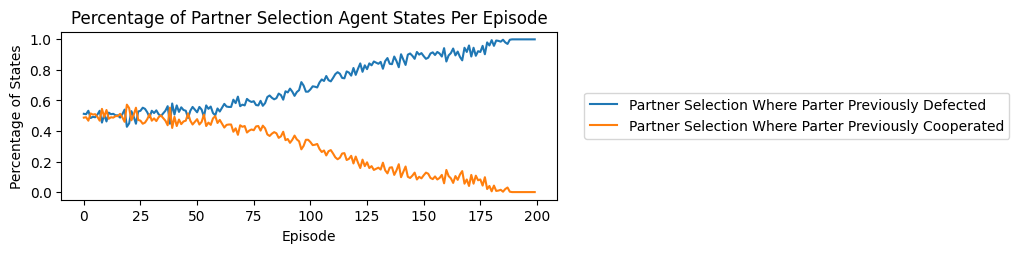

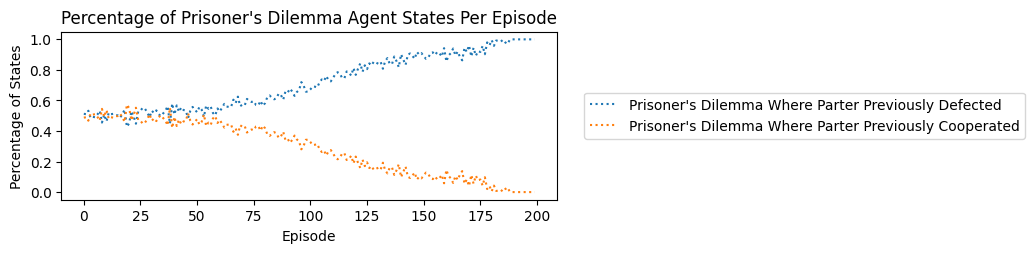

Agent 0) PS-Strategy: Always-Stay, PD-Strategy: Always-Defect
[[7.16946775 9.78883371]
 [8.57372557 8.98083747]]
[[ 9.78937448  7.6494786 ]
 [10.25949661  9.65437723]]
Agent 1) PS-Strategy: Always-Stay, PD-Strategy: Always-Defect
[[6.67069532 9.65682366]
 [8.1158881  8.30444988]]
[[9.6577025  7.19574683]
 [9.13937273 8.79691883]]
Agent 2) PS-Strategy: Always-Stay, PD-Strategy: Always-Defect
[[6.1701335  9.38051819]
 [7.9828788  8.15781546]]
[[9.38210462 6.73281218]
 [7.959598   7.65652828]]
Agent 3) PS-Strategy: Always-Stay, PD-Strategy: Always-Defect
[[7.05268672 9.5439755 ]
 [8.64871045 8.71238619]]
[[ 9.54514333  7.48106872]
 [10.15368819  9.32810123]]
Agent 4) PS-Strategy: Reverse-OFT, PD-Strategy: Always-Defect
[[6.56024993 9.47323501]
 [8.70462117 8.48775698]]
[[9.474584   7.2794668 ]
 [8.76315542 8.27016824]]
Agent 5) PS-Strategy: Always-Stay, PD-Strategy: Tit-For-Tat
[[6.61049737 9.61829103]
 [8.43138197 8.7789867 ]]
[[9.61926855 7.18286143]
 [9.03517913 9.23336598]]
Agent 6) P

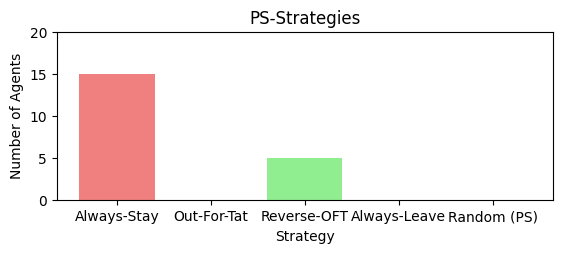

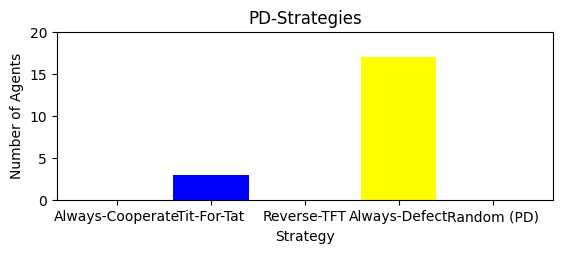

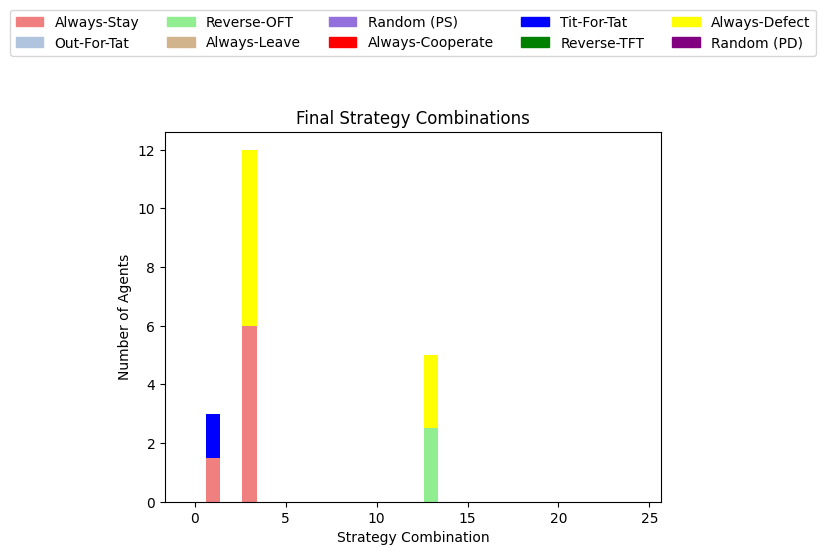

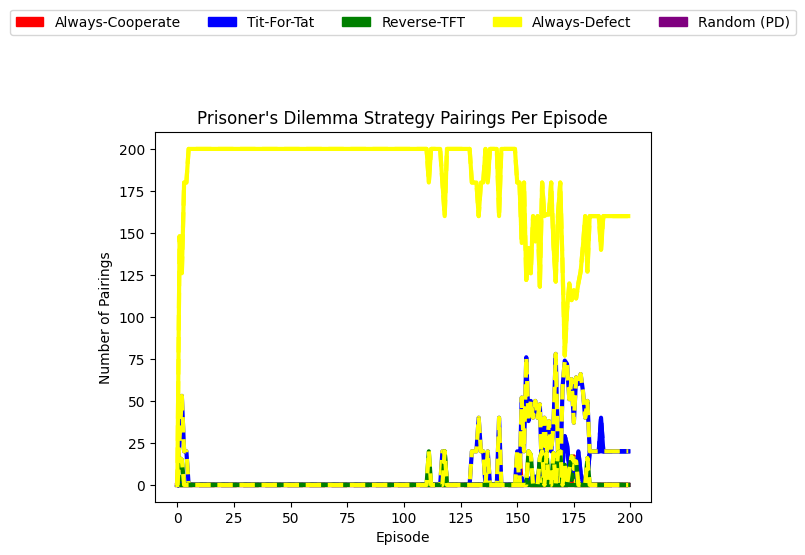

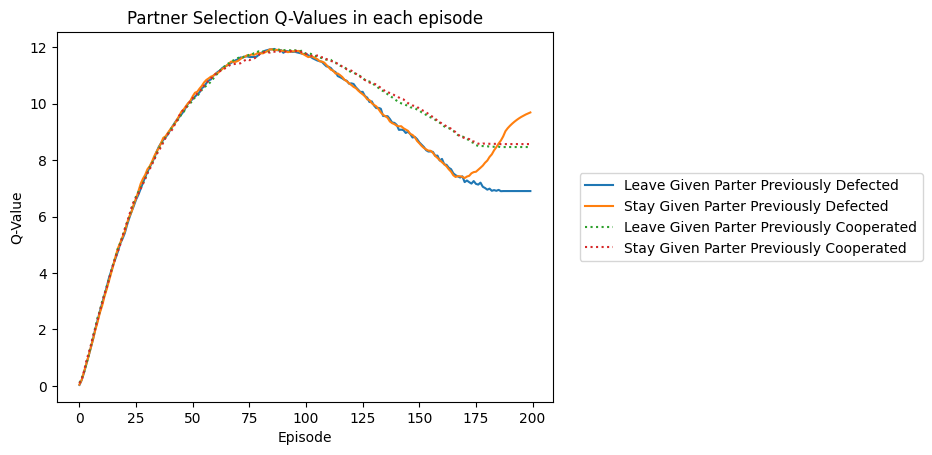

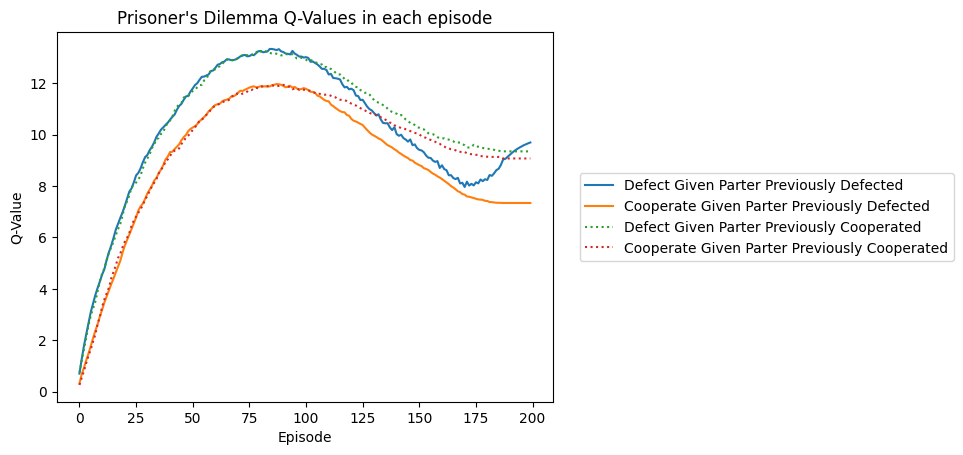

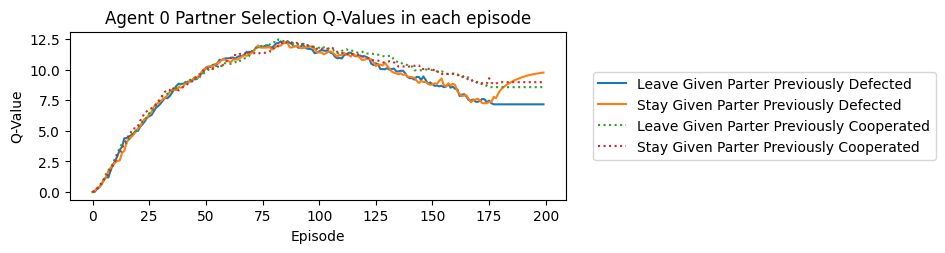

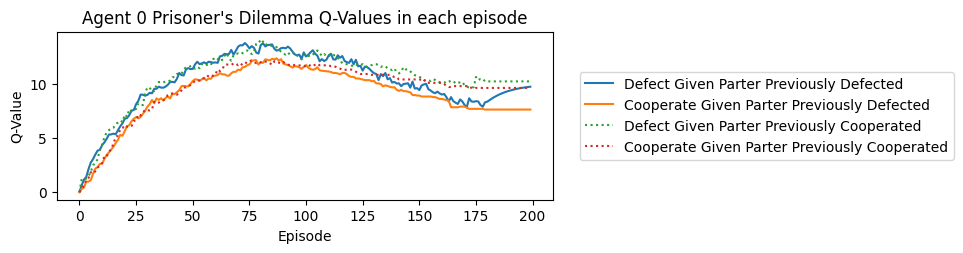

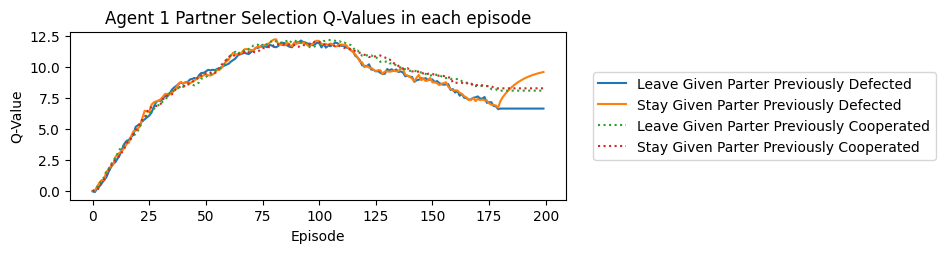

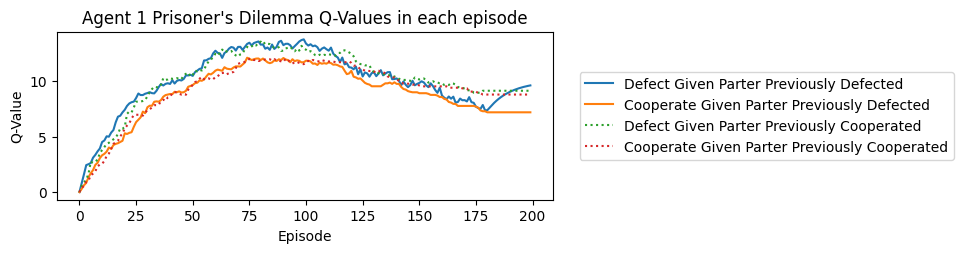

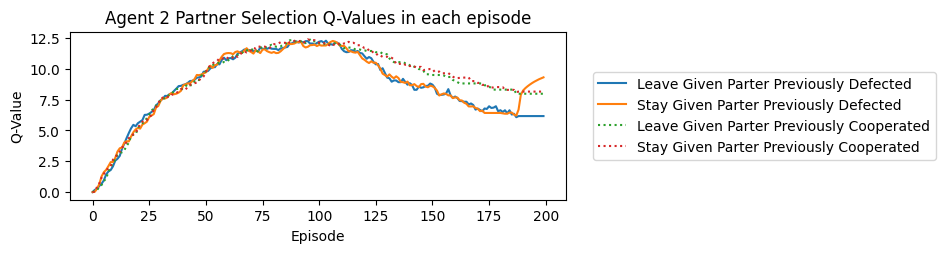

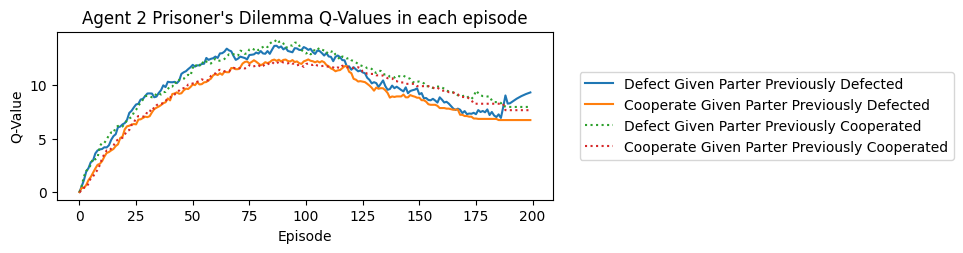

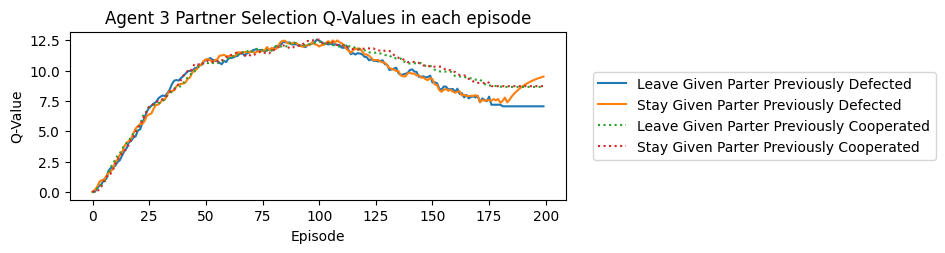

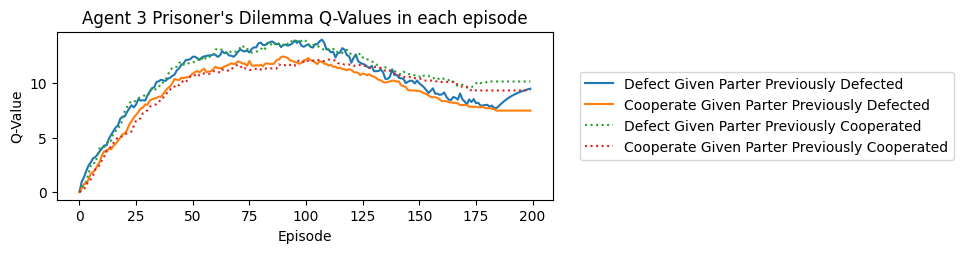

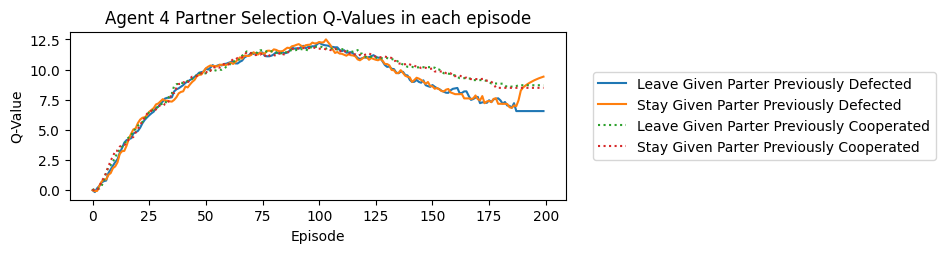

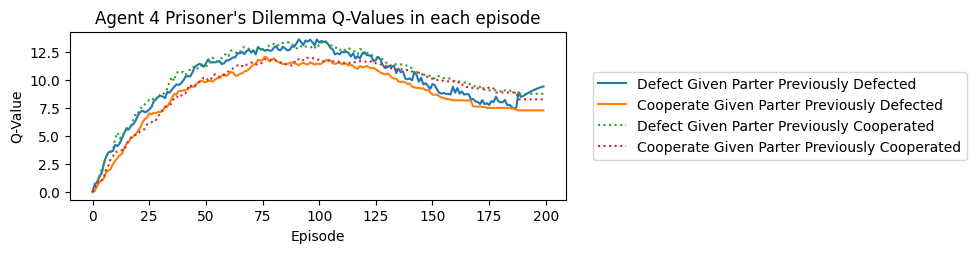

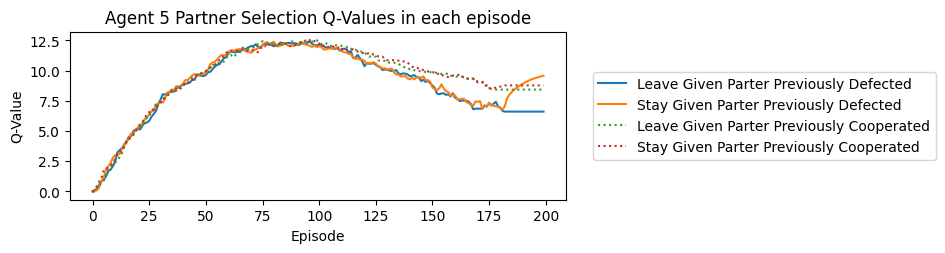

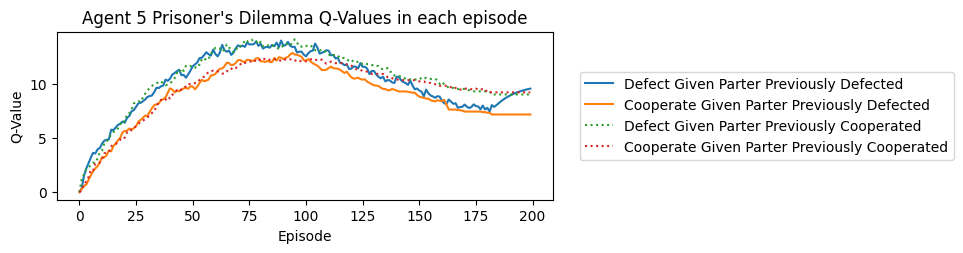

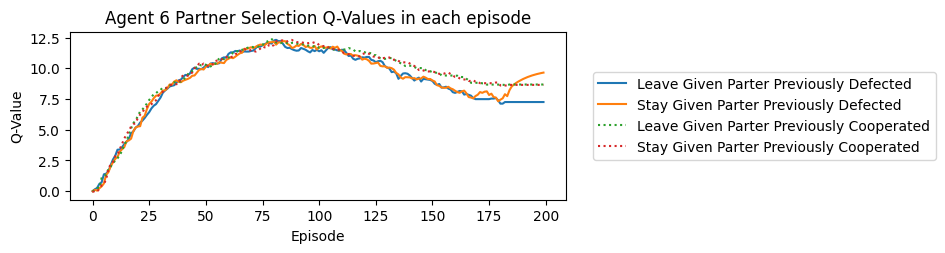

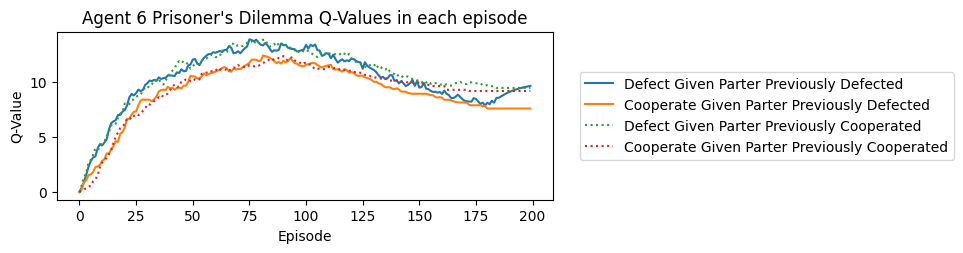

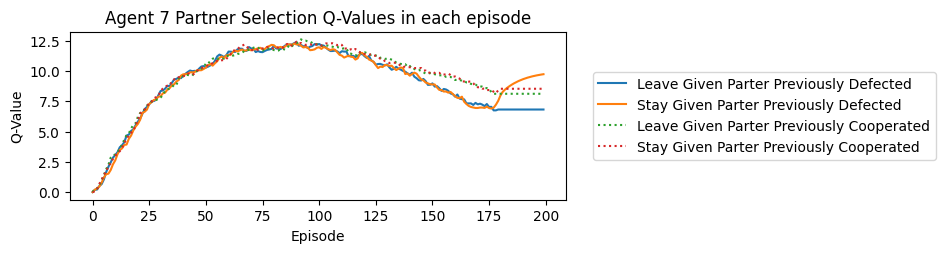

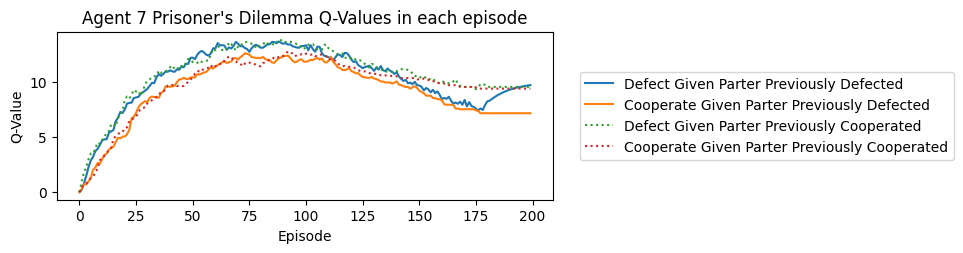

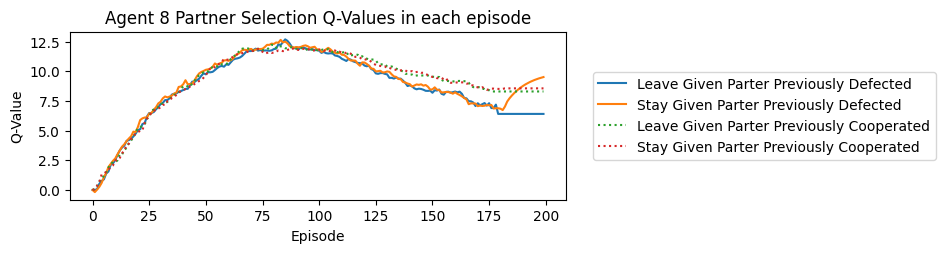

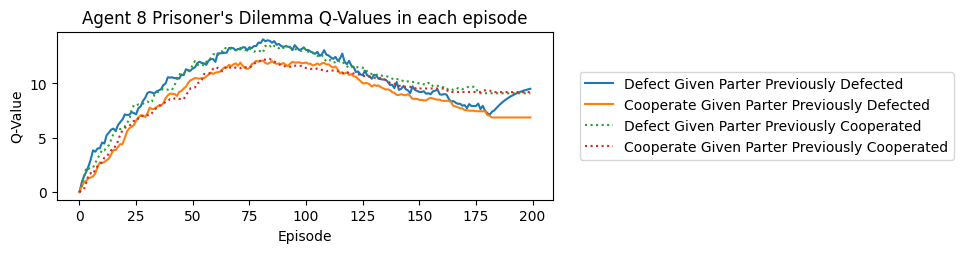

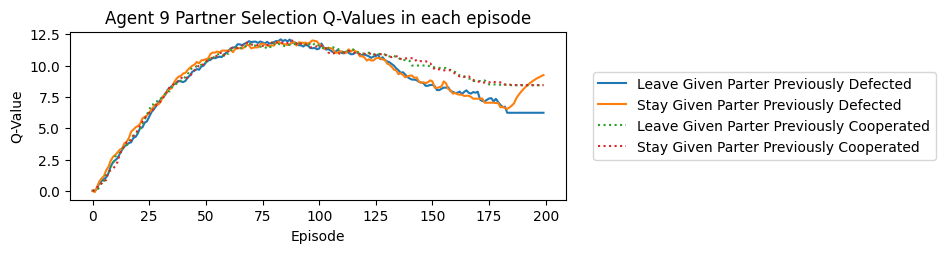

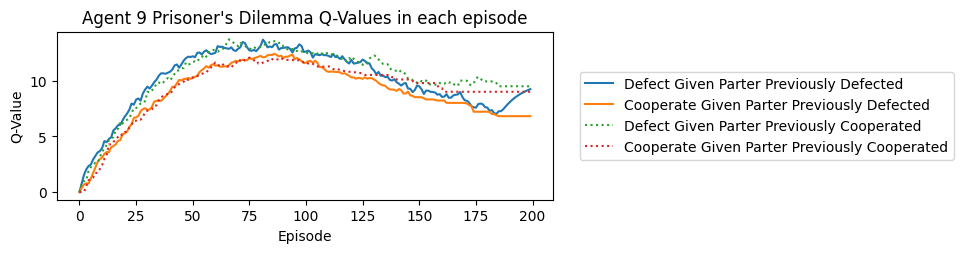

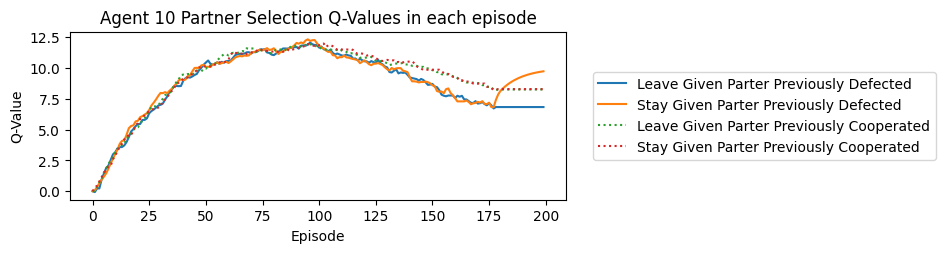

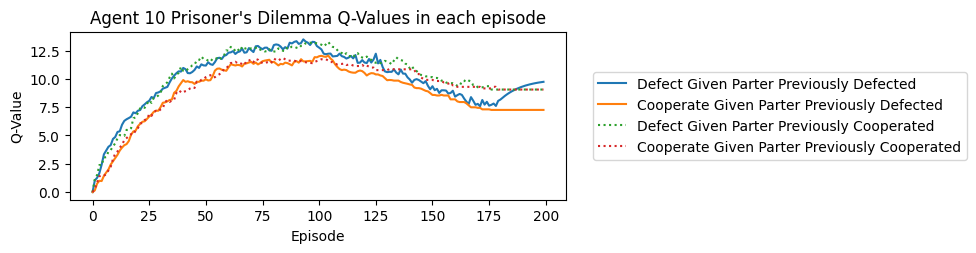

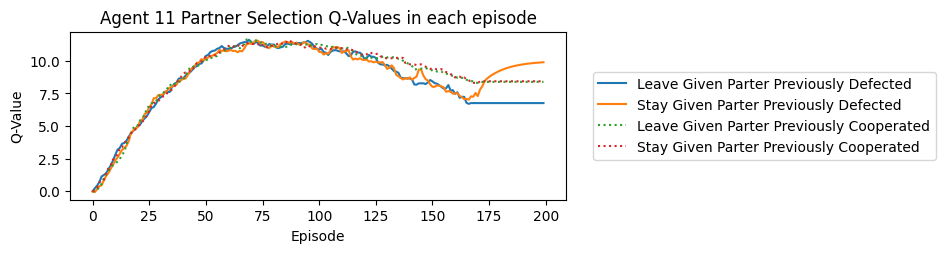

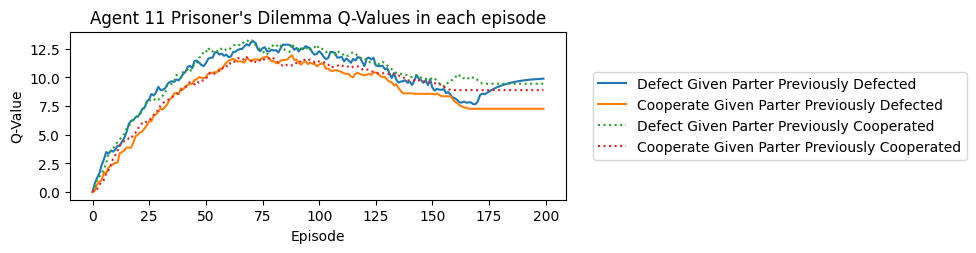

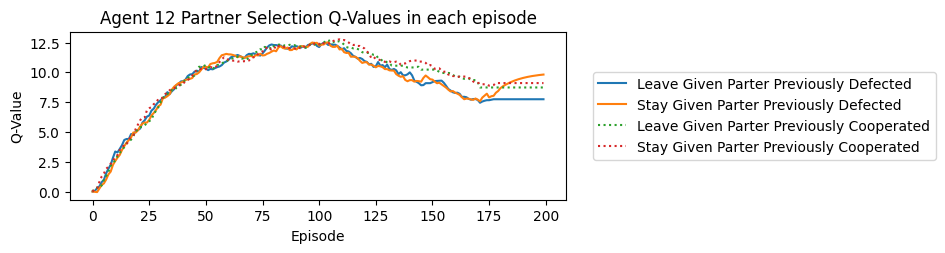

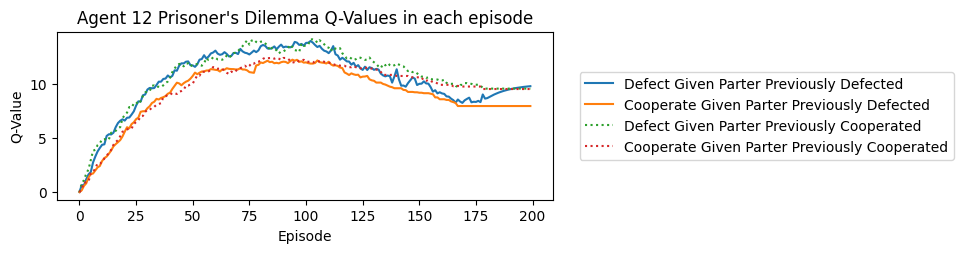

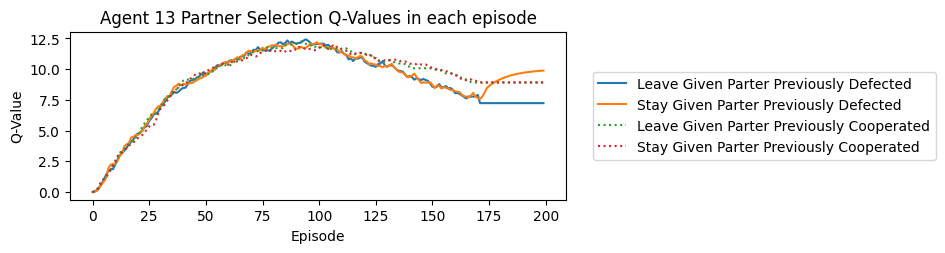

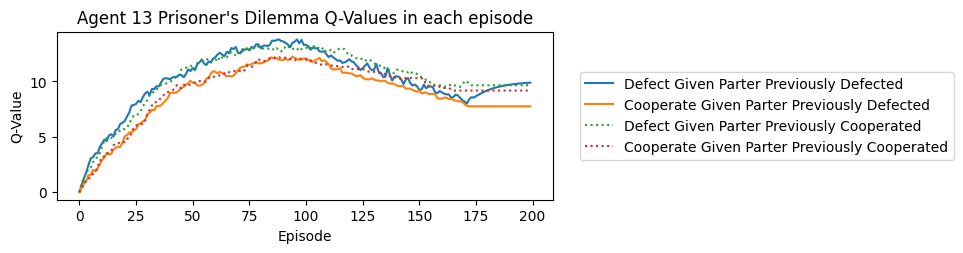

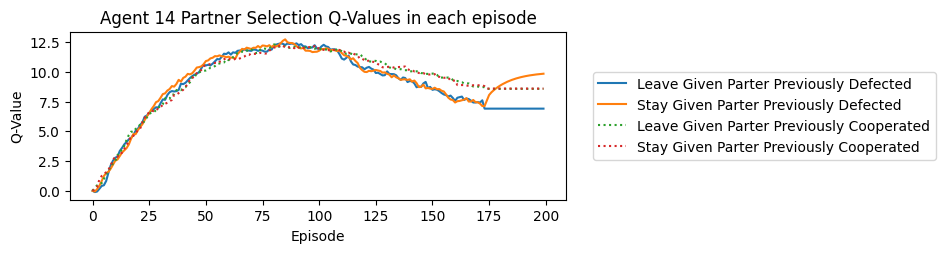

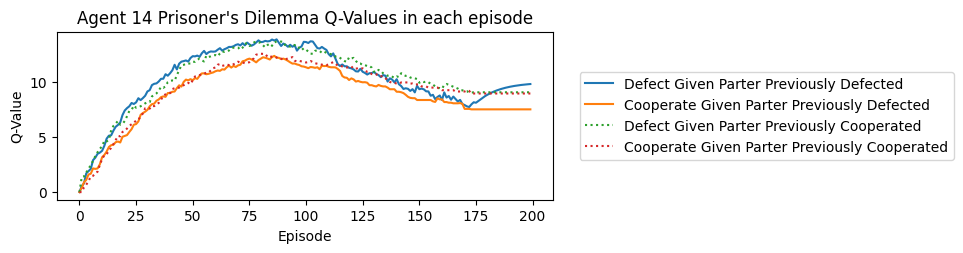

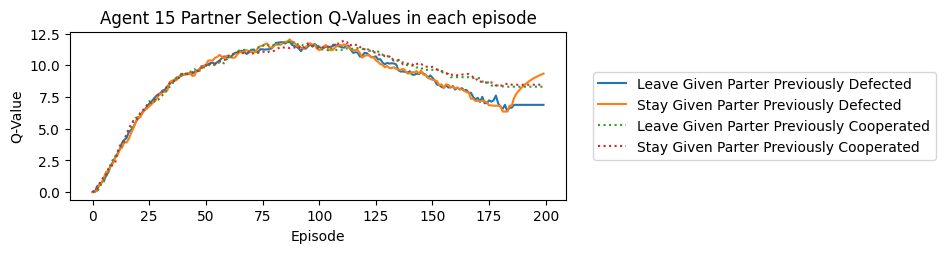

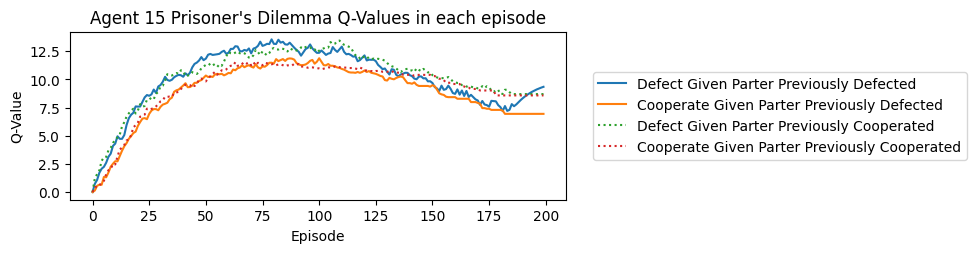

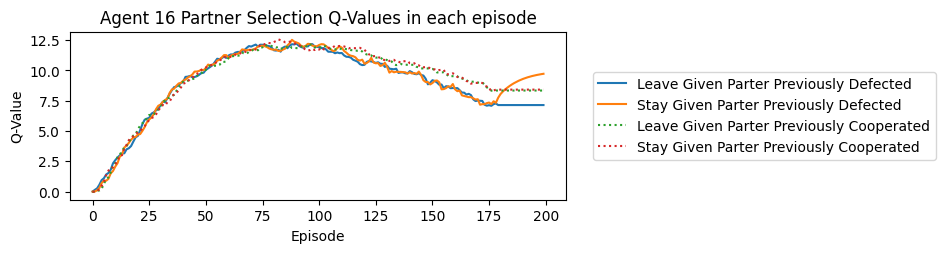

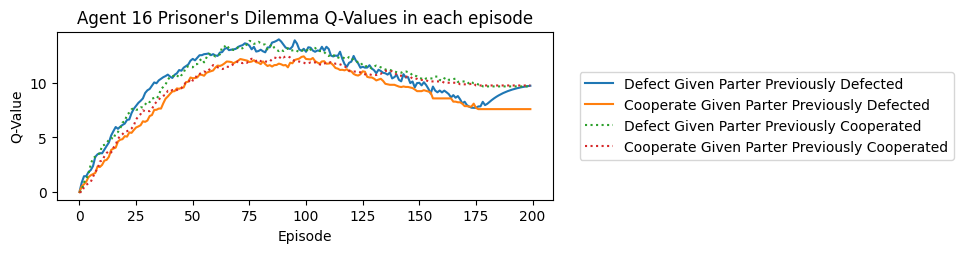

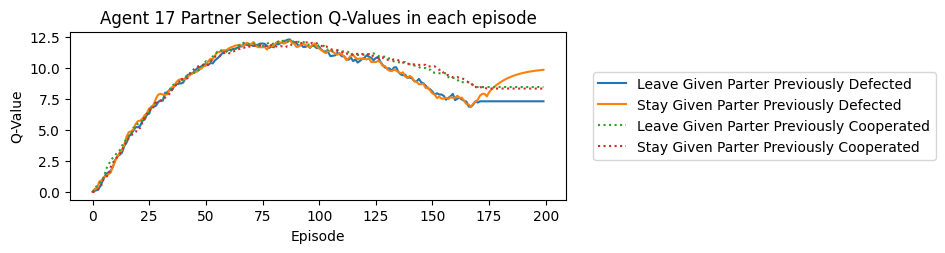

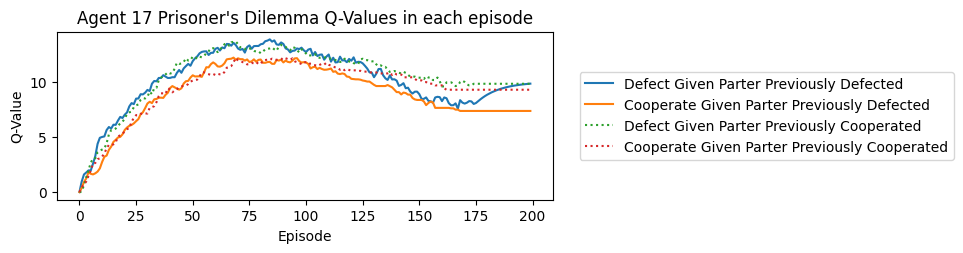

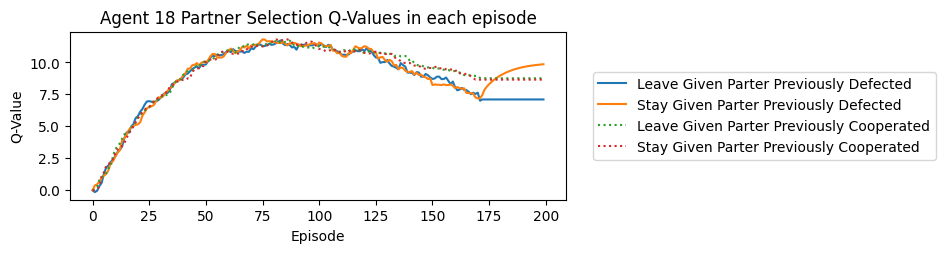

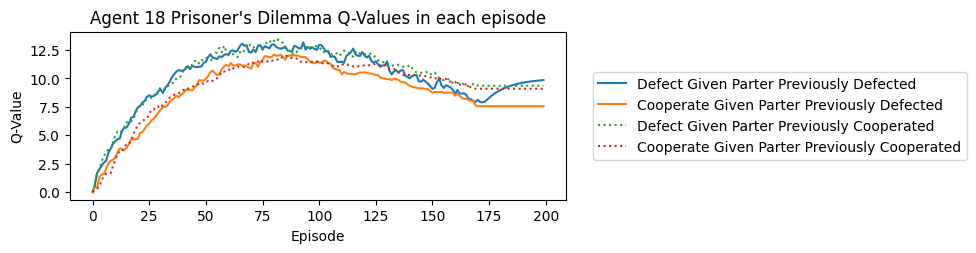

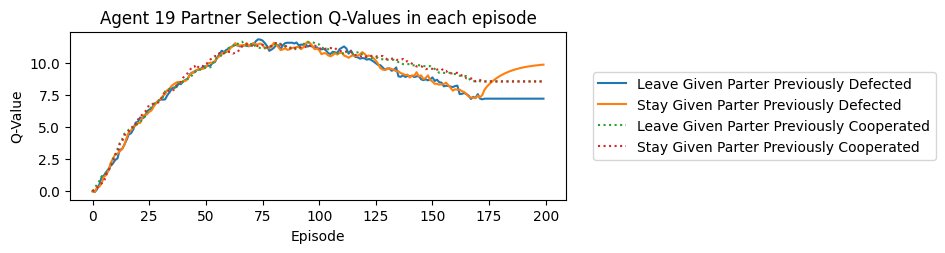

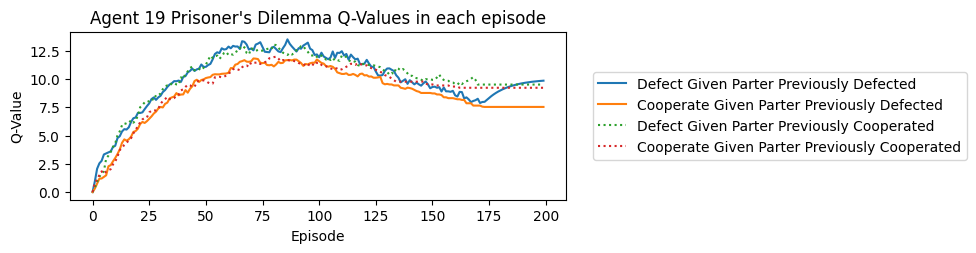

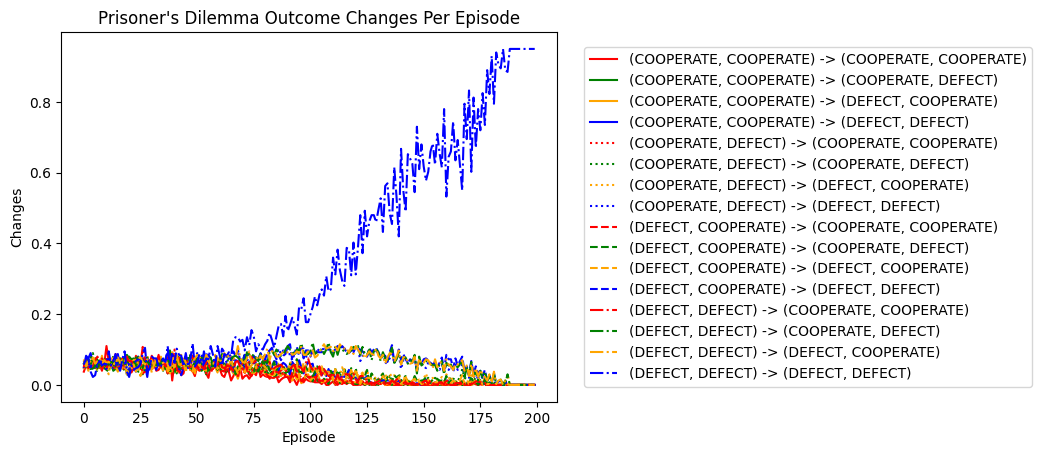

In [55]:
sdoo(20, 20, 200, 0.05, 85, 0.9)